**Градиентный спуск**

Среднеквадратичная ошибка имеет один минимум и непрерывна на всей области значений (то есть является выпуклой и гладкой), а значит в каждой ее точке можно посчитать частные производные.

Вспомним, что _градиентом_ функции $f$ называется $n$-мерный вектор из частных производных. 

$$ \nabla f(x_{1},...,x_{d}) = \left(\frac{\partial f}{\partial x_{i}}\right)^{d}_{i=1}.$$

При этом известно, что __градиент задает направление наискорейшего роста функции__. Значит, антиградиент будет показывать направление её скорейшего убывания, что будет полезно в задаче минимизации функционала ошибки.

Для решения задачи требуется определить некоторую стартовую точку и итерационно сдвигаться от неё в сторону антиградиента с определенным _шагом_ $\eta_{k}$, на каждом шаге пересчитывая градиент в точке, в которой мы находимся. Таким образом, имея начальный вектор весов $w^{0}$, $k$-й шаг градиентного спуска будет иметь вид

$$w^{k} = w^{k-1} - \eta_{k}\nabla Q(w^{k-1}, X).$$

Итерации следует продолжать, пока не наступает сходимость. Она определяется разными способами, но в даннном случае удобно определять как ситуацию, когда векторы весов от шага к шагу изменяются незначительно, то есть норма отклонения вектора весов на текущем шаге от предыдущего не привышает заданное значение $\varepsilon$:

$$||w^{k}-w^{k-1}|| < \varepsilon.$$

Начальный вектор весов $w_{0}$ также можно определять различными способами, обычно его берут нулевым или состоящим из случайных небольших чисел.

В случае многомерной регрессии (при количестве признаков больше 1) при оптимизации функционала ошибки 

$$Q(w, X) = \frac{1}{l}||Xw-y||^{2}\rightarrow \underset{w}{\text{min}}$$

формула вычисления градиента принимает вид

$$\nabla_{w}Q(w,X) = \frac{2}{l}X^{T}(Xw-y).$$

Задача линейной регрессии. Предсказание баллов, полученных на экзамене.

In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
np.random.seed(13)

In [268]:
# Сгенерировал данные
X, Y, coef = make_regression(n_samples=10000, n_features=2, n_informative=2, n_targets=1, 
                                      noise=5, coef=True, random_state=42)
X[:, 0] *= 20       # Добавил шума в первый признак
display(X, Y, coef)

array([[-11.38296397,   1.59040357],
       [ 14.69755572,   0.49097495],
       [  4.01397389,   1.10623156],
       ...,
       [-37.72257408,   0.13807841],
       [-20.31757654,  -0.9933587 ],
       [ 23.15039212,   0.54658973]])

array([ -49.6854239 ,   73.63062887,   20.15499442, ..., -192.63317609,
       -106.45952324,  118.37024675])

array([98.57676058,  5.56663928])

In [269]:
X.shape

(10000, 2)

In [270]:
Y.shape

(10000,)

In [271]:
def show_data(X, Y):  
  fig = plt.figure(figsize=(15,15))
  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(X[:, 0], X[:, 1], Y)

  ax.set_xlabel('X0')
  ax.set_ylabel('X1')
  ax.set_zlabel('Y')
  plt.show()

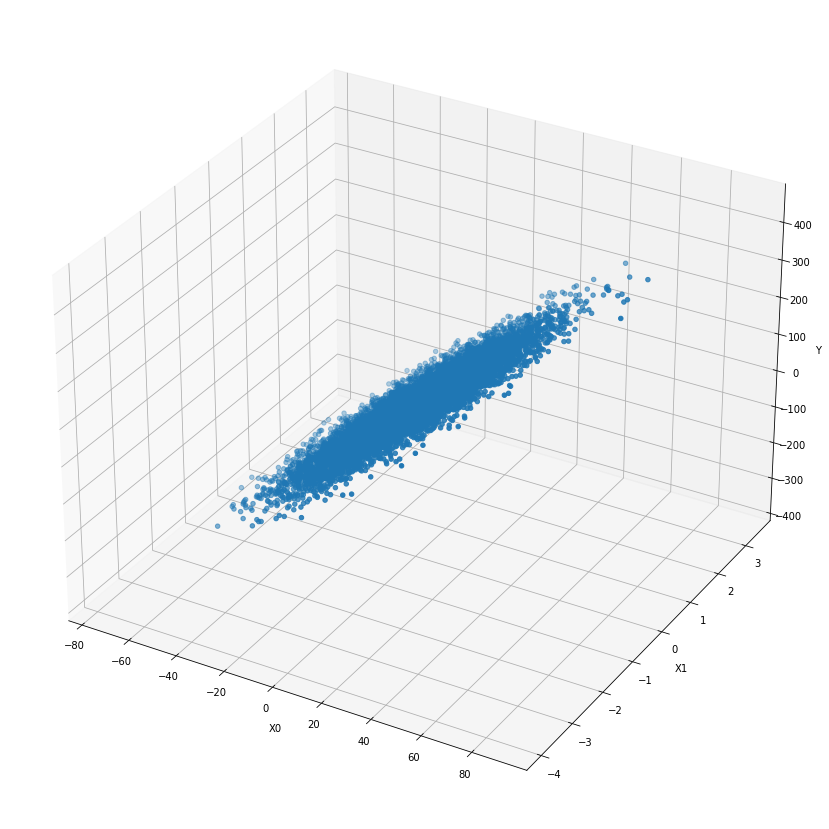

In [272]:
show_data(X, Y)

In [273]:
def standard_scale(X):
  """
  Функция для стандартизации признаков
  """
  return (X - X.mean()) / X.std()

In [274]:
def get_standard_scale(X):
  X_st = X.copy().astype(np.float64)

  for i in range(X_st.shape[1]):
    X_st[:, i] = standard_scale(X_st[:, i])
  return X_st

In [275]:
X_st = get_standard_scale(X)

In [276]:
def get_mse(y, y_pred):
  """
  Вычисление MSE
  """
  error = np.mean((y - y_pred)**2)
  return error

In [277]:
def simple_gradient_descent(X, y, iterations, eta):
  """
  Классический градиентный спуск (GD)
  """
  W = np.random.randn(X.shape[1])
  n = X.shape[0]
  errors = []
  
  for i in range(iterations):
    y_pred = np.dot(X, W)
    err = get_mse(y, y_pred)
    errors.append(err)
    # градиент функции ошибки
    dQ = 2/n * X.T @ (y_pred - y)
    W -= eta * dQ
    if i % 100 == 0:
      print(f'Iter {i}: weights {W} error {err}')
  print(f'\nFinal MSE: {err:.6f}\n')

In [278]:
def gradient_descent(X, y, eta):
  """
  Классический градиентный спуск (GD) с остановкой по сходимости весов
  """
  W = np.random.randn(X.shape[1])
  W_init = W.copy()
  n = X.shape[0]

  # Список значений ошибок после каждой итерации
  errors = []

  # Список значений весов после каждой итерации
  W_list = []

  # Начальная разница весов
  weight_dist = np.inf

  # Критерий сходимости (разница весов, при которой алгоритм останавливается)
  min_weight_dist = 1e-5

  # Счётчик итераций
  iter_num = 0

  print(f'Number of objects = {n} \
      \nLearning rate = {eta} \
      \nInitial weights = {W} \n')
  
  while weight_dist > min_weight_dist:

    y_pred = np.dot(X, W)
    err = get_mse(y, y_pred)
    errors.append(err)

    # Вычисляем градиент функции ошибки  
    dQ = 2/n * X.T @ (y_pred - y)        
    new_W = W - eta * dQ

    # Вычисляем расстояние между весами по норме Эвклида 
    weight_dist = np.linalg.norm(new_W - W, ord=2)

    # Логирование процесса
    if iter_num % 100 == 0:
      print(f'Iteration {iter_num}: weights {W} error {err}')

    iter_num += 1
    W = new_W.copy()
    W_list.append(W)
  
  print(f'\nFinal MSE: {err:.6f}')
  print(f'Number of iterations: {iter_num}\n')
  W_list = np.array(W_list)

  return W_list, errors, iter_num, W_init

In [279]:
# Стохастический градиентный спуск (SGD)
def stohastic_gradient_descent(X, y, size, eta):
  """
  Стохастический градиентный спуск (SGD) с остановкой по сходимости весов
  """
  W = np.random.randn(X.shape[1])
  W_init = W.copy()
  n = X.shape[0]

  # Список значений ошибок после каждой итерации
  errors = []

  # Список значений весов после каждой итерации
  W_list = []

  # Начальная разница весов
  weight_dist = np.inf

  # Критерий сходимости (разница весов, при которой алгоритм останавливается)
  min_weight_dist = 1e-4

  # Счётчик итераций
  iter_num = 0

  print(f'Number of objects = {n} \
      \nLearning rate = {eta} \
      \nInitial weights = {W} \n')
  
  while weight_dist > min_weight_dist:
    
    index = np.random.randint(n, size=size)
    y_pred = np.dot(X[index], W)
    err = get_mse(y, np.dot(X, W))
    errors.append(err)

    dQ = 2 / y[index].shape[0] * X[index].T @ (y_pred - y[index]) # градиент функции ошибки
    new_W = W - eta * dQ

    # Вычисляем расстояние между весами по норме Эвклида 
    weight_dist = np.linalg.norm(new_W - W, ord=1)
    
    # Логирование процесса
    if iter_num % 100 == 0:
      print(f'Iteration {iter_num}: weights {W} error {err}')
    
    iter_num += 1
    W = new_W.copy()
    W_list.append(W)
  
  print(f'\nFinal MSE: {err:.6f}')
  print(f'Number of iterations: {iter_num}\n')
  W_list = np.array(W_list)

  return W_list, errors, iter_num, W_init

In [280]:
%%time
simple_gradient_descent(X_st, Y, iterations=2000, eta=1e-2)

Iter 0: weights [1.26003338 0.84472829] error 9774.943327819456
Iter 100: weights [85.1005357   4.90375689] error 196.80983347419527
Iter 200: weights [96.2232381   5.51581728] error 28.12305237291514
Iter 300: weights [97.69889641  5.60677323] error 25.151682402839835
Iter 400: weights [97.89468182  5.62013395] error 25.099333486879356
Iter 500: weights [97.92065911  5.62207808] error 25.098411056314433
Iter 600: weights [97.92410599  5.62235877] error 25.098394799538237
Iter 700: weights [97.92456337  5.62239902] error 25.098394512982164
Iter 800: weights [97.92462407  5.62240476] error 25.09839450793022
Iter 900: weights [97.92463212  5.62240558] error 25.09839450784114
Iter 1000: weights [97.92463319  5.62240569] error 25.098394507839565
Iter 1100: weights [97.92463333  5.62240571] error 25.09839450783954
Iter 1200: weights [97.92463335  5.62240571] error 25.098394507839537
Iter 1300: weights [97.92463335  5.62240571] error 25.09839450783954
Iter 1400: weights [97.92463335  5.62240

In [281]:
%%time
W_list_gd, err_gd, iter_gd, W_init_gd = gradient_descent(X_st, Y, eta=1e-2)

Number of objects = 10000       
Learning rate = 0.01       
Initial weights = [-0.04450308  0.45181234] 

Iteration 0: weights [-0.04450308  0.45181234] error 9646.492767466789
Iteration 100: weights [84.9271793  4.8505   ] error 194.56283701200806
Iteration 200: weights [96.20020031  5.50860175] error 28.08373967720993
Iteration 300: weights [97.69583473  5.60579602] error 25.15099449859561
Iteration 400: weights [97.89427491  5.62000165] error 25.099321447931143
Iteration 500: weights [97.92060503  5.62206018] error 25.098410845589875
Iteration 600: weights [97.9240988   5.62235634] error 25.09839479584924

Final MSE: 25.098395
Number of iterations: 605

CPU times: user 99.2 ms, sys: 83.4 ms, total: 183 ms
Wall time: 97 ms


In [282]:
%%time
W_list_sgd, err_sgd, iter_sgd, W_init_sgd  = stohastic_gradient_descent(X_st, Y, size=1, eta=1e-2)

Number of objects = 10000       
Learning rate = 0.01       
Initial weights = [1.34510171 0.53233789] 

Iteration 0: weights [1.34510171 0.53233789] error 9375.418007853985
Iteration 100: weights [81.44050648  4.66002857] error 297.64789593265874
Iteration 200: weights [95.45956996  4.69299258] error 32.02385013594561
Iteration 300: weights [97.12860112  6.14873589] error 26.01180839637873
Iteration 400: weights [98.16632593  5.45749068] error 25.184265840634144
Iteration 500: weights [97.41070058  5.47660306] error 25.383292795784882
Iteration 600: weights [97.12540866  5.6234719 ] error 25.7371612971578
Iteration 700: weights [97.63689825  5.71969677] error 25.190833489883488
Iteration 800: weights [98.16986123  5.59593839] error 25.159273921363635
Iteration 900: weights [97.76946708  5.30972668] error 25.219923923413024
Iteration 1000: weights [97.69703896  5.88942779] error 25.22188949437586
Iteration 1100: weights [97.80215714  5.40146863] error 25.16203225278167

Final MSE: 25.1

In [283]:
def visualization_mse(iter_gd, iter_sgd, err_gd, err_sgd):
  """
  Функция визуализации изменения ошибки после каждой итерации для GD и SGD
  """
  plt.figure(figsize=(14, 10))
  plt.plot(range(iter_gd), err_gd, color='b', label='GD', alpha=0.8)
  plt.plot(range(iter_sgd), err_sgd, color='r',label='SGD', alpha=0.8)
  plt.title('Зависимость MSE от количества итераций')
  plt.xlabel('Число итераций')
  plt.ylabel('MSE')
  plt.xlim(0, 200)
  plt.legend()

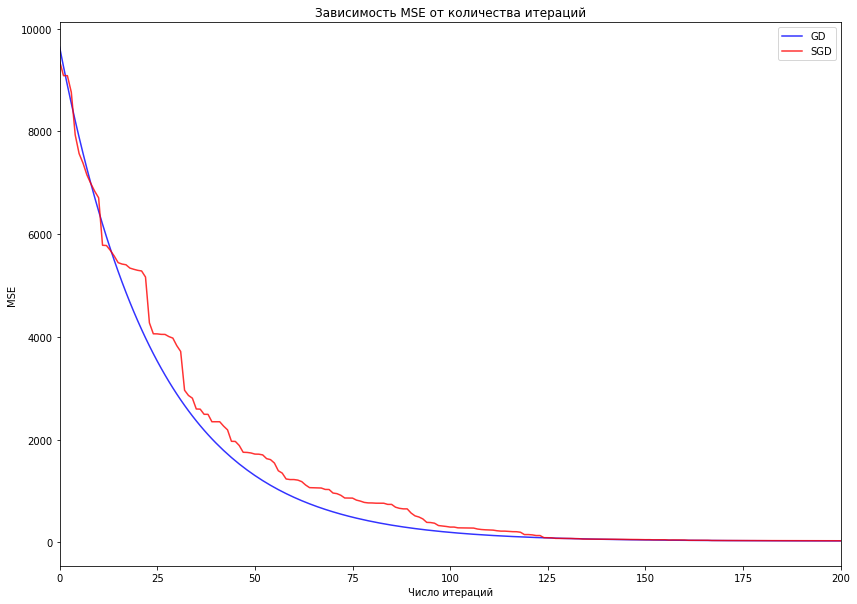

In [284]:
visualization_mse(iter_gd, iter_sgd, err_gd, err_sgd)

In [285]:
def visualization_weigths(W_init_gd, W_init_sgd, W_list_gd, W_list_sgd):
  """
  Функция визуализации изменения весов для GD и SGD
  """
  plt.figure(figsize=(25, 10))
  plt.title('Изменение весов')
  plt.xlabel(r'$w_1$')
  plt.ylabel(r'$w_2$')

  # Красной точкой обозначены веса, сгенерированные в начале алгоритма
  plt.scatter(W_init_gd[0], W_init_gd[1], c='r')
  plt.scatter(W_init_sgd[0], W_init_sgd[1], c='r')

  # Веса для GD
  plt.scatter(W_list_gd[:, 0], W_list_gd[:, 1])
  plt.plot(W_list_gd[:, 0], W_list_gd[:, 1], label='GD')

  # Веса для SGD
  plt.scatter(W_list_sgd[:, 0], W_list_sgd[:, 1])
  plt.plot(W_list_sgd[:, 0], W_list_sgd[:, 1], label='SGD')

  plt.legend(loc='upper left')
  plt.show()

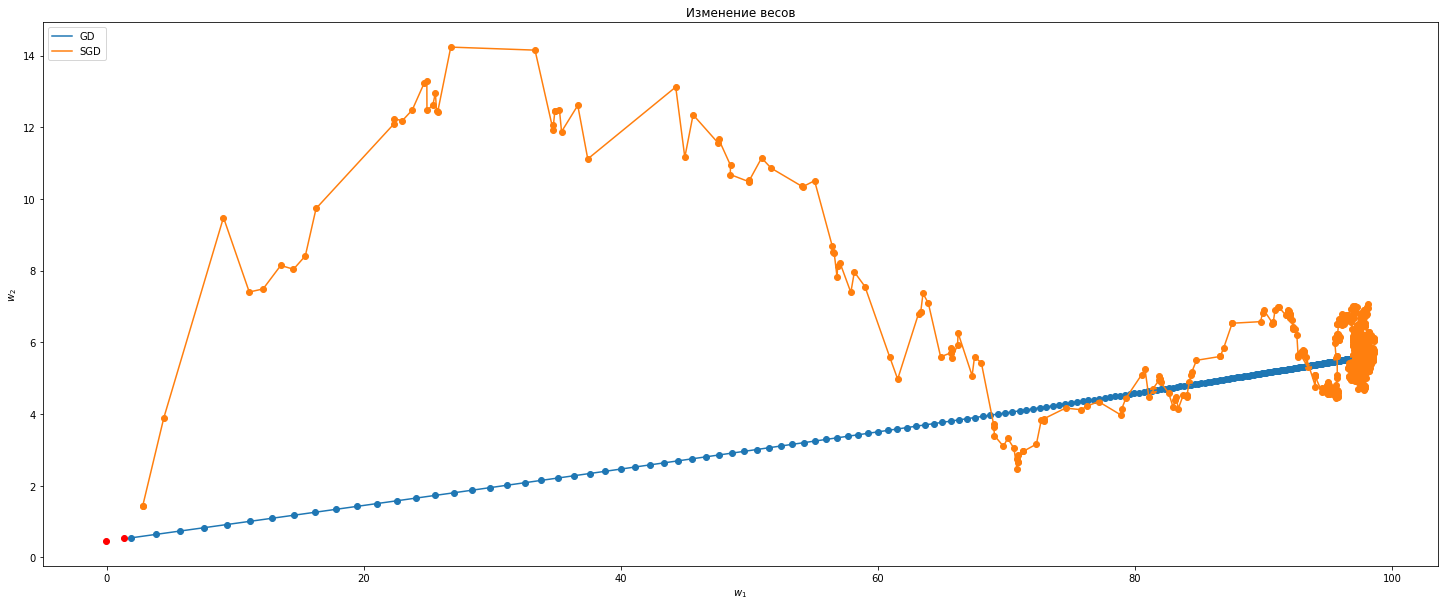

In [286]:
visualization_weigths(W_init_gd, W_init_sgd, W_list_gd, W_list_sgd)

**Реализация SGDRegressor из библиотеки sklearn**

In [287]:
# Классическое разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state = 42)

In [288]:
# Стандартизируем признаки
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [289]:
# Инициализируем модель и обучаем
reg = SGDRegressor()
reg.fit(X_train, y_train)

SGDRegressor()

In [290]:
# Получение предсказаний
pred = reg.predict(X_test)
pred

array([ 33.41987176, -14.72779077,  -6.35688854, ..., 285.23418292,
       100.52017602,  94.25184567])

In [291]:
# Смотрим коэффицент дереминации R^2, он близок к 1.0, что очень хорошо
reg.score(X_test,y_test)

0.9974573700107986

In [292]:
# Вычислим ошибку предсказаний MSE
mse_reg = mean_squared_error(y_test, pred)
mse_reg

24.8899196371666

**Выводы:**

Взглянем на MSE "самодельной" функции и предсказания модели SGDRegressor

In [293]:
print(f'MSE Gradient descent: {err_gd[-1]:.6f}')
print(f'MSE Stohastic gradient descent: {err_sgd[-1]:.6f}')
print(f'MSE SGDRegressor: {mse_reg:.6f}')

MSE Gradient descent: 25.098395
MSE Stohastic gradient descent: 25.148764
MSE SGDRegressor: 24.889920


Как видим, функция из коробки чуть-чуть лучше, ну совсем чуть-чуть

Теперь взглянем на веса полученные разными методами 

In [294]:
print(f'Веса при инициализации датасета: {coef}')
print(f'Веса Gradient descent: {W_list_gd[-1]}')
print(f'Веса Stohastic gradient descent: {W_list_sgd[-1]}')
print(f'Веса SGDRegressor: {reg.coef_}')

Веса при инициализации датасета: [98.57676058  5.56663928]
Веса Gradient descent: [97.92415015  5.62236093]
Веса Stohastic gradient descent: [98.12468089  5.52135876]
Веса SGDRegressor: [97.5078721   5.59462533]


Разница в весах тоже незначительна